### Amazon Book Reviews: Review of the top 50 reviewers: Clustering and feature selection from review text

The original dataset has ~9 million reviews: http://jmcauley.ucsd.edu/data/amazon/.  I have created a subset which contains data of reviewers who have done maximum number of reviews. I did an EDA on the dataset in part I of this notebook. I noticed that some reviewers sound like a corporate name, e.g., Midwest Book Reviews whereas others are individual personnel, e.g., Harriet Klausner. Here we will see if we can differentiate between corporate and individual accounts by reviewing their texts.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("top50_reviewers_with_book_title_and_rank.csv")

In [3]:
df = df.drop("Unnamed: 0", axis = 1)

In [4]:
df.tail(2)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title,rank
128756,A281NPSIMI1C2R,"Rebecca of Amazon ""The Rebecca Review""",0307338312,220,248,2008-02-24 00:00:00 UTC,Deepak Chopra's new book is not quite as contr...,312,3,Is Jesus just an Enlightened Master?,The Third Jesus: The Christ We Cannot Ignore,461913.0
128757,A14OJS0VWMOSWO,Midwest Book Review,0895949903,248,251,2001-03-12 00:00:00 UTC,The Herbal Medicine-Makers Handbook blends the...,58,5,Far more in-depth than your usual herbal recip...,The Herbal Medicine-Maker's Handbook: A Home M...,8306.0


In [5]:
len(df)

128758

#### Let's take the reviews with at least 2 votes and then sample a subset of 10000. 

In [6]:
dr = df[df.totalVote > 1]
len(dr)

81639

In [7]:
dr1 = dr.sort_values(by ='rank')[:10000] # Take top 10000 best selling books

In [8]:
#dr1 = dr.sample(n = 10000, random_state=123)
#dr1.head(1)

In [9]:
len(dr1)

10000

#### Now let's separate corporate accounts from the individuals. I did it manually just by looking at names once I grouped by reviewer names.

** Corporate accounts** 
A14OJS0VWMOSWO, Midwest Book Review, A2F6N60Z96CAJI, Bookreporter, A320TMDV6KCFU, MNix, 
A13QTZ8CIMHHG4, LAS Reviewer "The Long and the Short Of It Re..., A2TX179XAT5GRP, TeensReadToo "Eat. Drink. Read. Be Merrier."
A21NVBFIEQWDSG, Armchair Interviews, A2VKWLCNZF4ZVB, The RAWSISTAZ Reviewers, A1JKGTL51HHTU1, Under The Covers Book Blog, 
A26J2TRDPZH7RZ, Romancing the Book, A2CR57GAJKNWVV, booksforabuck "BooksForABuck", A3U7ELIED4WP4R, Dark Faerie Tales

** There are 11 corporate reviewers out of 50 **

In [10]:
corporate_list = ["A14OJS0VWMOSWO", "A2F6N60Z96CAJI", "A320TMDV6KCFU", "A13QTZ8CIMHHG4", "A2TX179XAT5GRP",
                 "A21NVBFIEQWDSG", "A2VKWLCNZF4ZVB", "A1JKGTL51HHTU1", "A26J2TRDPZH7RZ", "A2CR57GAJKNWVV", "A3U7ELIED4WP4R"]

In [11]:
dr2 = dr1.replace([corporate_list], 'corporate') 

In [12]:
dr2_corporate = dr2[dr2.reviewerID == "corporate"]
len(dr2_corporate)

2687

In [13]:
dr2_individual = dr2[dr2.reviewerID != "corporate"]
len(dr2_individual)

7313

In [14]:
individual_list = dr2_individual.reviewerID

In [15]:
dr3_individual = dr2_individual.replace([individual_list], "individual")
dr3_individual.head(1)

,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title,rank
96477,individual,Jane,0345803485,10,14,2012-02-01 00:00:00 UTC,FIFTY SHADES OF GREY by E L James.This is grap...,830,3,"I enjoyed much of it, but I wanted more plot. ...",Fifty Shades of Grey: Book One of the Fifty Sh...,10.0


In [16]:
dr4_individual = dr3_individual.sample(n = 2687) # Taking 2687 samples because the corporate list also contains the same.
len(dr4_individual)

2687

In [17]:
dr4 = pd.concat([dr2_corporate, dr4_individual]) # The list where reviewerIds are categorzed as corporate and individual

In [18]:
len(dr4)

5374

dr4 has equal number of corporate and individual reviews and I labeled reviewerIDs as corporate/individual. Now I am going to write some functions for review text analysis. Some of these codes are from http://brandonrose.org/clustering

In [19]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [20]:
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, KernelPCA

In [21]:
add_text = ["book"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")

Let's make a vocabulary dictionary from the review summary. Later I am going to create the same from the review texts. 

In [22]:
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in dr4.summary:
    allwords_stemmed = tokenize_and_stem(i) 
    totalvocab_stemmed.extend(allwords_stemmed) 

    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = vocab_frame.drop(add_text)
vocab_frame.head()

,words
courtesi,courtesy
of,of
teen,teens
read,read
too,too


In [23]:
vocab_frame.shape

(41777, 1)

Now let's use Term frequency inverse document frequency (Tfidf) vectorizer to get features from the summary.

In [24]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
                                     min_df=30, stop_words=set(my_stop_words),
                                     use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1)) #Notice tfidf parameters

In [25]:
%time tfidf_matrix = tfidf_vectorizer.fit_transform(dr4.summary) 

Wall time: 1.87 s


### Terms and idf values

In [26]:
terms = tfidf_vectorizer.get_feature_names()
terms[:10]

[u"'s",
 u'action',
 u'addit',
 u'adventur',
 u'age',
 u'american',
 u'ani',
 u'anoth',
 u'anyon',
 u'art']

In [27]:
idf = tfidf_vectorizer.idf_

In [28]:
term_idf= pd.DataFrame(dict(idf=idf, term= terms))
#term_idf = term_idf.set_index("idf")
term_idf.sort_index(ascending = False)[:20]

,idf,term
133,5.760872,young
132,5.978596,year
131,5.600530,written
130,5.657688,write
129,5.341019,world
128,5.025166,work
127,5.245708,wonder
126,5.657688,way
125,6.155527,war
124,5.495169,want


#### Phrase scores

In [29]:
dense = tfidf_matrix.todense()

In [30]:
dense = tfidf_matrix.todense()
len(dense[0].tolist()[0])
review_dense = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(review_dense)), review_dense)]
len(phrase_scores)

134

In [31]:
top_numbers = 100
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
top_words = []
top_score = []
top =[]
for phrase, score in [(terms[word_id], score) 
    for (word_id, score) in sorted_phrase_scores][:top_numbers]:
        #print('{0: <20} {1}'.format(phrase, round(score,5)))
        top.append({'Feature_Name':phrase, 'Score':score})
        top_words.append(phrase)
        top_score.append(int(score*100))

pd.DataFrame(top)[:10]

,Feature_Name,Score
0,courtesi,0.631852
1,teen,0.622513
2,read,0.461780
3,'s,0.000000
4,action,0.000000
5,addit,0.000000
6,adventur,0.000000
7,age,0.000000
8,american,0.000000
9,ani,0.000000


#### We can define a function which would take a dataframe and returns top words per clusters

In [32]:
from __future__ import print_function
from sklearn.feature_extraction import text
from sklearn.cluster import KMeans
from sklearn.externals import joblib
import numpy as np

#add_text = np.array (["book", "'s", "read", "good", "tale", "love", "excellent", "great", "any", "recommended", "highly",
                     #"joyfully", "n't", "wonderfully", "wonder", "wonderful", "best", "anything", "anyone", "beautiful",
            #"enthusiastically", "very", "sf", "free", "super", "exciting", "excellent", "terrific", "enjoyed", "fantastic",
            #"important", "story", "recommended", "readers", "novel", "any", "excellent", "excellence", "recommend", 
            #"recommendation", "read", "reader", "readers", "beauty"])

add_text = ["book", "'s", "n't" ]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)
stemmer = SnowballStemmer("english")

def reviewer_cluster_summary (dataframe, num_clusters, n_words):
     
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    
    for i in dataframe.summary:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    vocab_frame = vocab_frame.drop(my_stop_words)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(analyzer=u'word', max_df=0.8, 
        max_features=10000, 
        min_df=30, 
        stop_words=my_stop_words,
                                         use_idf=True, 
        tokenizer=tokenize_and_stem, 
                                               ngram_range=(1,1)) # See the min_df, max_df and ngram_ranges

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.summary) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
    idf = tfidf_vectorizer_cluster.idf_
    
    term_idf = pd.DataFrame(dict(idf=idf, term= terms))
    term_idf = term_idf.sort_values(by = "idf", ascending = False)[:20]
    
    print (term_idf)
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    pca = PCA(n_components=2).fit(tfidf_matrix_cluster_dense)
    data2D = pca.transform(tfidf_matrix_cluster_dense)
    
    dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = dataframe.asin, title=dataframe.title, 
                                   reviewer=dataframe.reviewerID))
    
    km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=50)
   
    
    dataframe1 ['clusterID'] = km.fit_predict(data2D)
    
    centroids = km.cluster_centers_
    sns.lmplot(x = 'x', y = 'y', hue = "reviewer", data=dataframe1, fit_reg= False, scatter_kws={"s": 100},
              palette=dict(corporate="m", individual="b")) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=3)
    plt.title ("2D PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster22.pkl')
    km = joblib.load('doc_cluster22.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of reviewers in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top features per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :n_words]: 
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() 
        print() 
        
        corporate = []
        individual = []
        for reviewer in dataframe.ix[i]['reviewerID'].values.tolist():
            if reviewer == 'corporate':
                corporate.append(reviewer)
            else:
                individual.append(reviewer)
        print ("Number of reviews from corporate accounts: ", len (corporate))  
        print ("Number of reviews from individual accounts:", len(individual))
        print() #add whitespace
        print()
        print("Cluster %d reviewer:" % i, end='')
        
        for reviewer in dataframe.ix[i]['reviewerName'].unique():
            print(' %s,' % reviewer, end='')
        print() #add whitespace
        print() #add whitespace
        
        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'].values.tolist()[:10]:
            print(' %s,' % book, end='')
        print() 
        print() 
    print() 
    print()

          idf      term
123  6.155527       war
51   6.155527     humor
46   6.155527    health
102  6.155527   spiritu
10   6.155527     basic
0    6.123778    action
58   6.123778   intrigu
79   6.093006  outstand
92   6.093006    realli
113  6.063153     think
26   6.063153       doe
31   6.063153     everi
8    6.063153       art
99   6.063153    scienc
22   6.063153      cook
23   6.063153  cookbook
72   6.034166       man
59   6.034166       joy
15   6.034166     chang
9    6.034166    author


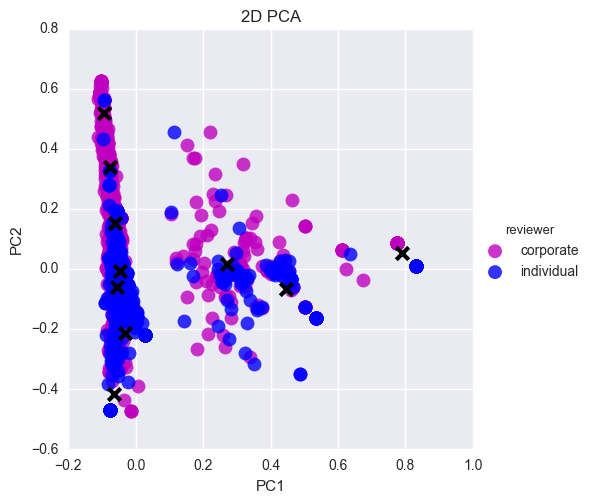


Number of reviewers in each cluster:
4    3866
3     322
6     293
8     196
9     184
5     139
1     107
0      99
7      92
2      76
Name: clusterName, dtype: int64

Top features per cluster:

Cluster 0 top words: best, novel, series, years, read, making, collection, thriller, science, start,

Number of reviews from corporate accounts:  35
Number of reviews from individual accounts: 64


Cluster 0 reviewer: Under The Covers Book Blog, Bookreporter, Midwest Book Review, Armchair Interviews, LAS Reviewer "The Long and the Short Of It Re..., Robert Beveridge "xterminal", D. Blankenship, S. Schwartz "romonko", Shalom Freedman "Shalom Freedman", Robert Morris, E. R. Bird "Ramseelbird", A. Ross, M. Heiss, Donald Mitchell "Jesus Loves You!", Loyd E. Eskildson "Pragmatist", Harriet Klausner, Charles Ashbacher, E. A Solinas "ea_solinas", Michael K. Smith, Steven H. Propp, Jane, Rebecca of Amazon "The Rebecca Review", Thomas Duff "Duffbert", Luan Gaines "luansos",

Cluster 0 books: Entwined

In [33]:
reviewer_cluster_summary(dr4, 10, 10)

I am going to discuss a couple of points about the above analysis. 

<p> 1. I played with max_df and min_df in the above function and looked at the terms (as shown below). max_df is a cut off point after which it ignore terms that have a higher document frequency. I set it for 0.8 meaning that if some terms occur 80% of the time in a corpus I am going to discard it. min_df is the terms that should be in certain number of documents before it's going to be added in the vocabulary. I set min_df=30, meaning that out of 6000 documents I am analyzing, the terms should be in at least 30 of them (0.05%). 

2. n_gram range is taken as (1, 1). so the term "science fiction" will be represented as "science" and "fiction" - these two different terms in the bag of words. I have also played with (1, 2) and (1,3) n_gram ranges. (1, 2) would have taken "science", "fiction" and "science fiction" these three terms. 

3. The PCA plot shows the clusters and cluster centers. I have taken 10 clusters and 10 words closest to the cluster centers. The number of clusters were chosen just by looking at the PCA plot so that we can have words from each segment. 
 

5. One cluster is particularly dense with about ~3800 reviews. We are going to further divide this cluster-


#### Cluster # 2 has 3968 elements. We can further split this cluster

In [37]:
len(dr4[dr4.clusterName == 4])

3866

In [38]:
dr5 = dr4[dr4.clusterName == 4]

         idf        term
11  5.826247     delight
47  5.826247       peopl
41  5.826247        mani
67  5.826247        true
12  5.826247         doe
34  5.826247       learn
58  5.826247        star
60  5.794498       studi
1   5.794498       anoth
13  5.794498       engag
68  5.794498  understand
64  5.794498     thought
7   5.763727    children
5   5.763727        busi
10  5.763727       color
30  5.763727      import
2   5.763727       anyon
16  5.733874       excit
45  5.733874       offer
74  5.704886       write


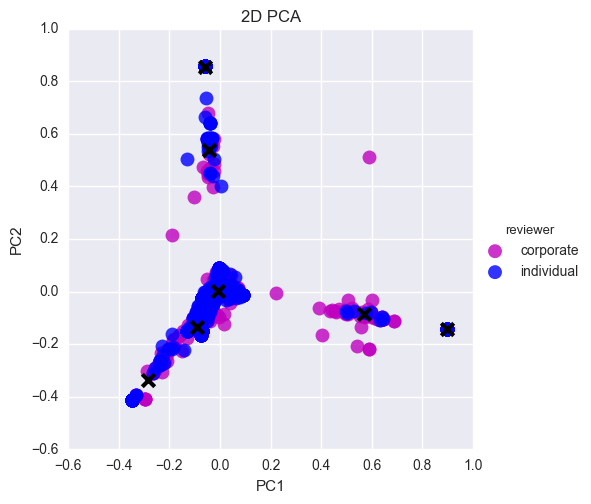

C:\Users\Bis\Anaconda2\lib\site-packages\ipykernel\__main__.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Number of reviewers in each cluster:
1    3337
5     105
4     101
2      90
3      89
0      79
6      65
Name: clusterName, dtype: int64

Top features per cluster:

Cluster 0 top words: life, guide, look, helping, people, time, making, tale, lively, history,

Number of reviews from corporate accounts:  47
Number of reviews from individual accounts: 32


Cluster 0 reviewer: Bookreporter, Midwest Book Review, Armchair Interviews, Romancing the Book, MNix, The RAWSISTAZ Reviewers, Grady Harp, Robert Morris, Rebecca of Amazon "The Rebecca Review", John Matlock "Gunny", Donald Mitchell "Jesus Loves You!", Luan Gaines "luansos", Charles Ashbacher, Thomas Duff "Duffbert", Shalom Freedman "Shalom Freedman", E. A Solinas "ea_solinas", Rolf Dobelli "getAbstract", Robert Beveridge "xterminal", E. Bukowsky "booklover10", Jerry Saperstein, Harriet Klausner, Jane, Cheryl Koch,

Cluster 0 books: Orphan Train: A Novel, The World According to Humphrey, A Visit from the Goon Squad, Updike, The Round 

In [39]:
reviewer_cluster_summary(dr5, 7, 10)

### Clustering of reviewers from review texts

In [40]:
from __future__ import print_function

add_text = [ "'s", "book", "n't", "klausner" ] 

def reviewer_cluster_text (dataframe, num_clusters, n_words):
    
    from sklearn.cluster import KMeans
    from sklearn.externals import joblib
    
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.reviewText:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(max_df=0.6, max_features=10000,
                                         min_df=80, # don't forget to change it to 80 mad max df =0.6
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1))

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.reviewText) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
    idf = tfidf_vectorizer_cluster.idf_
    
    term_idf = pd.DataFrame(dict(idf=idf, term= terms))
    term_idf = term_idf.sort_values(by = "idf", ascending = False)[:20]
    
    print (term_idf)
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    pca = PCA(n_components=2).fit(tfidf_matrix_cluster_dense)
    data2D = pca.transform(tfidf_matrix_cluster_dense)
    
    dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = dataframe.asin, title=dataframe.title, 
                                   reviewer=dataframe.reviewerID))
    
    km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=50)
   
    
    dataframe1 ['clusterID'] = km.fit_predict(data2D)
    
    centroids = km.cluster_centers_
    sns.lmplot(x = 'x', y = 'y', hue = "reviewer", data=dataframe1, fit_reg= False, scatter_kws={"s": 100},
              palette=dict(corporate="m", individual="b")) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=3)
    plt.title ("2D PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster22.pkl')
    km = joblib.load('doc_cluster22.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of reviewers in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top features per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :n_words]: 
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() 
        print() 
        
        corporate = []
        individual = []
        for reviewer in dataframe.ix[i]['reviewerID'].values.tolist():
            if reviewer == 'corporate':
                corporate.append(reviewer)
            else:
                individual.append(reviewer)
        print ("Number of reviews from corporate accounts: ", len (corporate))  
        print ("Number of reviews from individual accounts:", len(individual))
        print() #add whitespace
        print()
        print("Cluster %d reviewer:" % i, end='')
        
        for reviewer in dataframe.ix[i]['reviewerName'].unique():
            print(' %s,' % reviewer, end='.')
        print() #add whitespace
        print() #add whitespace
        
        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'].values.tolist()[:10]:
            print(' %s,' % book, end='.')
        print() 
        print() 
    print() 
    print()

In [41]:
len(dr4)

5374

In [42]:
dr6 = dr4.sample(n = 1000, random_state=123) # a smaller sample size for analyzing texts

In [43]:
len(dr6[dr6.reviewerID == "corporate"]) #Number of corporate reviews out of a 1000 total

480

          idf     term
55   3.514306  describ
156  3.514306   murder
234  3.514306     stay
211  3.514306   return
193  3.514306  process
105  3.514306     head
69   3.514306    event
11   3.514306      ask
140  3.502036       ll
52   3.502036     dead
152  3.502036      men
14   3.502036      bad
75   3.502036   expect
206  3.502036    refer
267  3.502036   writer
125  3.502036      kid
42   3.502036    color
160  3.502036     near
154  3.502036     miss
172  3.489914   origin


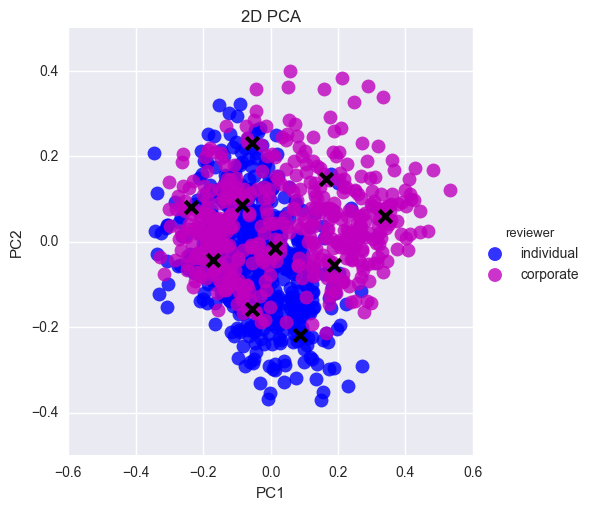


Number of reviewers in each cluster:
6    176
4    167
1    167
0    109
8     86
3     79
5     75
7     56
2     46
9     39
Name: clusterName, dtype: int64

Top features per cluster:

Cluster 0 top words: series, characters, want, does, story, novel, ending, read, way, love,

Number of reviews from corporate accounts:  63
Number of reviews from individual accounts: 46


Cluster 0 reviewer: Bookreporter,. LAS Reviewer "The Long and the Short Of It Re...,. K. Eckert "Devourer of all books fantasy",. Donald Mitchell "Jesus Loves You!",. Robert Beveridge "xterminal",. E. A Solinas "ea_solinas",. Midwest Book Review,. Harriet Klausner,. E. Bukowsky "booklover10",. A. Ross,. Armchair Interviews,. TeensReadToo "Eat. Drink. Read. Be Merrier.",. D. Blankenship,. Cheryl Koch,. MNix,. Gail Cooke,. Dii,. Nash Black "Troubadour",. Jerry Saperstein,. Shalom Freedman "Shalom Freedman",. Blue Tyson "- Research Finished",. Under The Covers Book Blog,. Dark Faerie Tales,. S. Schwartz "romonko",. Tho

In [44]:
reviewer_cluster_text(dr6, 10, 10)

In [45]:
add_text = ["book", "'s", "n't", "o", "s", "t"]
my_stop_words = text.ENGLISH_STOP_WORDS.union(add_text)

In [46]:
def reviewer_cluster_text_top_100 (dataframe, num_clusters, n_words):
    
    from sklearn.cluster import KMeans
    from sklearn.externals import joblib
    
    
    totalvocab_stemmed = []
    totalvocab_tokenized = []
    for i in dataframe.reviewText:
        allwords_stemmed = tokenize_and_stem(i) 
        totalvocab_stemmed.extend(allwords_stemmed) 

        allwords_tokenized = tokenize_only(i)
        totalvocab_tokenized.extend(allwords_tokenized)

    vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
    
    tfidf_vectorizer_cluster = TfidfVectorizer(max_df=0.7, max_features=10000,
                                         min_df=5, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1))

    tfidf_matrix_cluster = tfidf_vectorizer_cluster.fit_transform(dataframe.reviewText) 
    
    terms = tfidf_vectorizer_cluster.get_feature_names()
    idf = tfidf_vectorizer_cluster.idf_
    
    term_idf = pd.DataFrame(dict(idf=idf, term= terms))
    term_idf = term_idf.sort_values(by = "idf", ascending = False)[:20]
    
    print (term_idf)
   
    tfidf_matrix_cluster_dense = tfidf_matrix_cluster.todense()
    
    pca = PCA(n_components=2).fit(tfidf_matrix_cluster_dense)
    data2D = pca.transform(tfidf_matrix_cluster_dense)
    
    dataframe1 = pd.DataFrame(dict(x=data2D[:,0], y=data2D[:,1], asin = dataframe.asin, title=dataframe.title, 
                                   reviewer=dataframe.reviewerID))
    
    km = KMeans(n_clusters=num_clusters, random_state= 123, n_init=50)
   
    
    dataframe1 ['clusterID'] = km.fit_predict(data2D)
    
    centroids = km.cluster_centers_
    sns.lmplot(x = 'x', y = 'y', hue = "reviewer", data=dataframe1, fit_reg= False, scatter_kws={"s": 100},
              palette=dict(corporate="m", individual="b")) 
    plt.scatter(centroids[:, 0], centroids[:, 1], marker = "x", color = 'k', s=80, linewidths=3)
    plt.title ("2D PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
    
    km.fit(tfidf_matrix_cluster)
    clusters = km.labels_.tolist()

    joblib.dump(km,  'doc_cluster22.pkl')
    km = joblib.load('doc_cluster22.pkl')
    clusters = km.labels_.tolist()
    dataframe['clusterName'] = clusters
    print()
    print ("Number of reviewers in each cluster:")
    print (dataframe.clusterName.value_counts())
    dataframe = dataframe.set_index('clusterName')
    print()
    print("Top features per cluster:")
    print()

    #sort cluster centers by proximity to centroid
    order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

    for i in range(num_clusters):
        print("Cluster %d top words:" % i, end='')

        for ind in order_centroids[i, :n_words]: 
            print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        print() 
        print() 
        
        corporate = []
        individual = []
        for reviewer in dataframe.ix[i]['reviewerID'].values.tolist():
            if reviewer == 'corporate':
                corporate.append(reviewer)
            else:
                individual.append(reviewer)
        print ("Number of reviews from corporate accounts: ", len (corporate))  
        print ("Number of reviews from individual accounts:", len(individual))
        print() #add whitespace
        print()
        print("Cluster %d reviewer:" % i, end='')
        
        for reviewer in dataframe.ix[i]['reviewerName'].unique():
            print(' %s,' % reviewer, end='.')
        print() #add whitespace
        print() #add whitespace
        
        print("Cluster %d books:" % i, end='')
        for book in dataframe.ix[i]['title'].values.tolist()[:10]:
            print(' %s,' % book, end='.')
        print() 
        print() 
    print() 
    print()

In [47]:
dr100 = dr4.sort_values(by='rank')[:100] # Take 100 top books but there are same books reviewed by top reviewers

          idf        term
826  3.823361     younger
227  3.823361       emerg
673  3.823361       singl
205  3.823361  disappoint
668  3.823361    signific
667  3.823361        shot
665  3.823361       shock
209  3.823361         don
210  3.823361        door
663  3.823361         sex
215  3.823361       drink
657  3.823361       separ
225  3.823361      effect
654  3.823361        send
229  3.823361     employe
675  3.823361         sit
230  3.823361     encount
233  3.823361      energi
647  3.823361    scientif
241  3.823361   establish


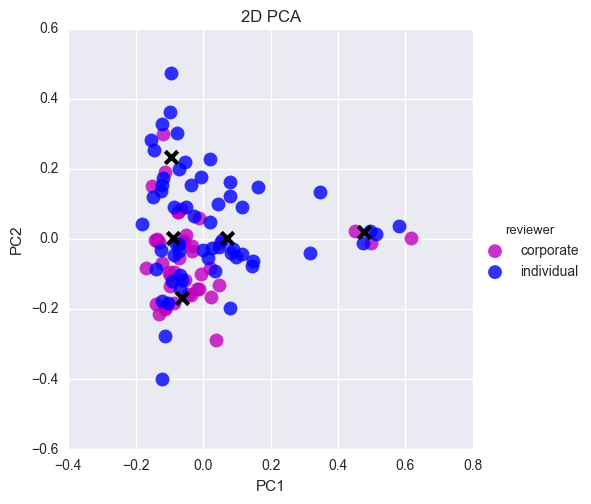


Number of reviewers in each cluster:
1    44
4    19
2    17
3    11
0     9
Name: clusterName, dtype: int64

Top features per cluster:

Cluster 0 top words: parents, child, sleeps, children, 'll, leads, school, read, babies, relationships,

Number of reviews from corporate accounts:  5
Number of reviews from individual accounts: 4


Cluster 0 reviewer: Donald Mitchell "Jesus Loves You!",. TeensReadToo "Eat. Drink. Read. Be Merrier.",. Midwest Book Review,. Robert Morris,. Blue Tyson "- Research Finished",. Jbarr5 (julie Barrett),. Bookreporter,.

Cluster 0 books: Oh, The Places You'll Go!,. An Abundance of Katherines,. The Conscious Parent: Transforming Ourselves, Empowering Our Children,. The Whole-Brain Child: 12 Revolutionary Strategies to Nurture Your Child's Developing Mind,. The Pearl,. The No-Cry Sleep Solution: Gentle Ways to Help Your Baby Sleep Through the Night,. The Cat in the Hat,. Where the Wild Things Are,. Where'd You Go, Bernadette: A Novel,.

Cluster 1 top words: st

In [48]:
reviewer_cluster_text_top_100(dr100, 5, 10)

### Multidimensional Scaling and Hierarchical Clustering

In [49]:
tfidf_vectorizer_linkage = TfidfVectorizer(max_df=0.7, max_features=10000,
                                         min_df=5, 
                                            stop_words=set(my_stop_words),
                                         use_idf=True, 
                                tokenizer=tokenize_and_stem, ngram_range=(1, 1))

%time tfidf_matrix_linkage = tfidf_vectorizer_linkage.fit_transform(dr100.reviewText) 

Wall time: 1.72 s


In [50]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix_linkage)

In [51]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

dr100['x_mds'] = pos[:, 0]
dr100['y_mds'] = pos[:, 1]
dr100.head(1)

Wall time: 382 ms


,reviewerID,reviewerName,asin,helpfulVote,totalVote,unixReviewTime,reviewText,wordLength,overall,summary,title,rank,clusterName,x_mds,y_mds
63271,corporate,"TeensReadToo ""Eat. Drink. Read. Be Merrier.""",014241543X,7,9,2009-04-10 00:00:00 UTC,Gold Star Award Winner!Mia has a lot to love i...,390,5,Courtesy of Teens Read Too,If I Stay,1.0,1,0.137374,0.3912


In [58]:
dr100.clusterName.value_counts()

1    44
4    19
2    17
3    11
0     9
Name: clusterName, dtype: int64

In [59]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names from dr100 K-means clusreting words 
cluster_names = {0: 'parents, child, sleeps, children, leads, school, babies', 
                 1: 'story, read, love, work, people, life, becomes, wanted, ', 
                 2: 'kids, color, pages, read, pictures, big, says, children', 
                 3: 'decision, tips, pointing, make, trains, unconsciously, study,',
                 4: 'fair, father, story, evil, novel, city, years, killed, building'}

In [60]:
import mpld3
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

In [61]:
groups = dr100.groupby('clusterName')

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
  font-family:Arial, Helvetica, sans-serif;
}

g.mpld3-xaxis, g.mpld3-yaxis {
display: none; }

svg.mpld3-figure {
margin-left: -200px;}
"""

# Plot 
fig, ax = plt.subplots(figsize=(14, 7)) #set plot size
ax.margins(0.25) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(group['x_mds'], group['y_mds'], marker='o', linestyle='', ms=12, 
                     label=cluster_names[name], mec='none',
                     color=cluster_colors[name])
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(points[0], labels,
                                       voffset=10, hoffset=10, css=css)
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    #ax.axes.get_xaxis().set_visible(True)
    #ax.axes.get_yaxis().set_visible(True)

    
ax.legend(numpoints=1) #show legend with only one dot

mpld3.display() #show the plot
#mpld3.save_html(fig, "my_fig.html")
#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)

In [62]:
name = dr100.reviewerName.tolist()

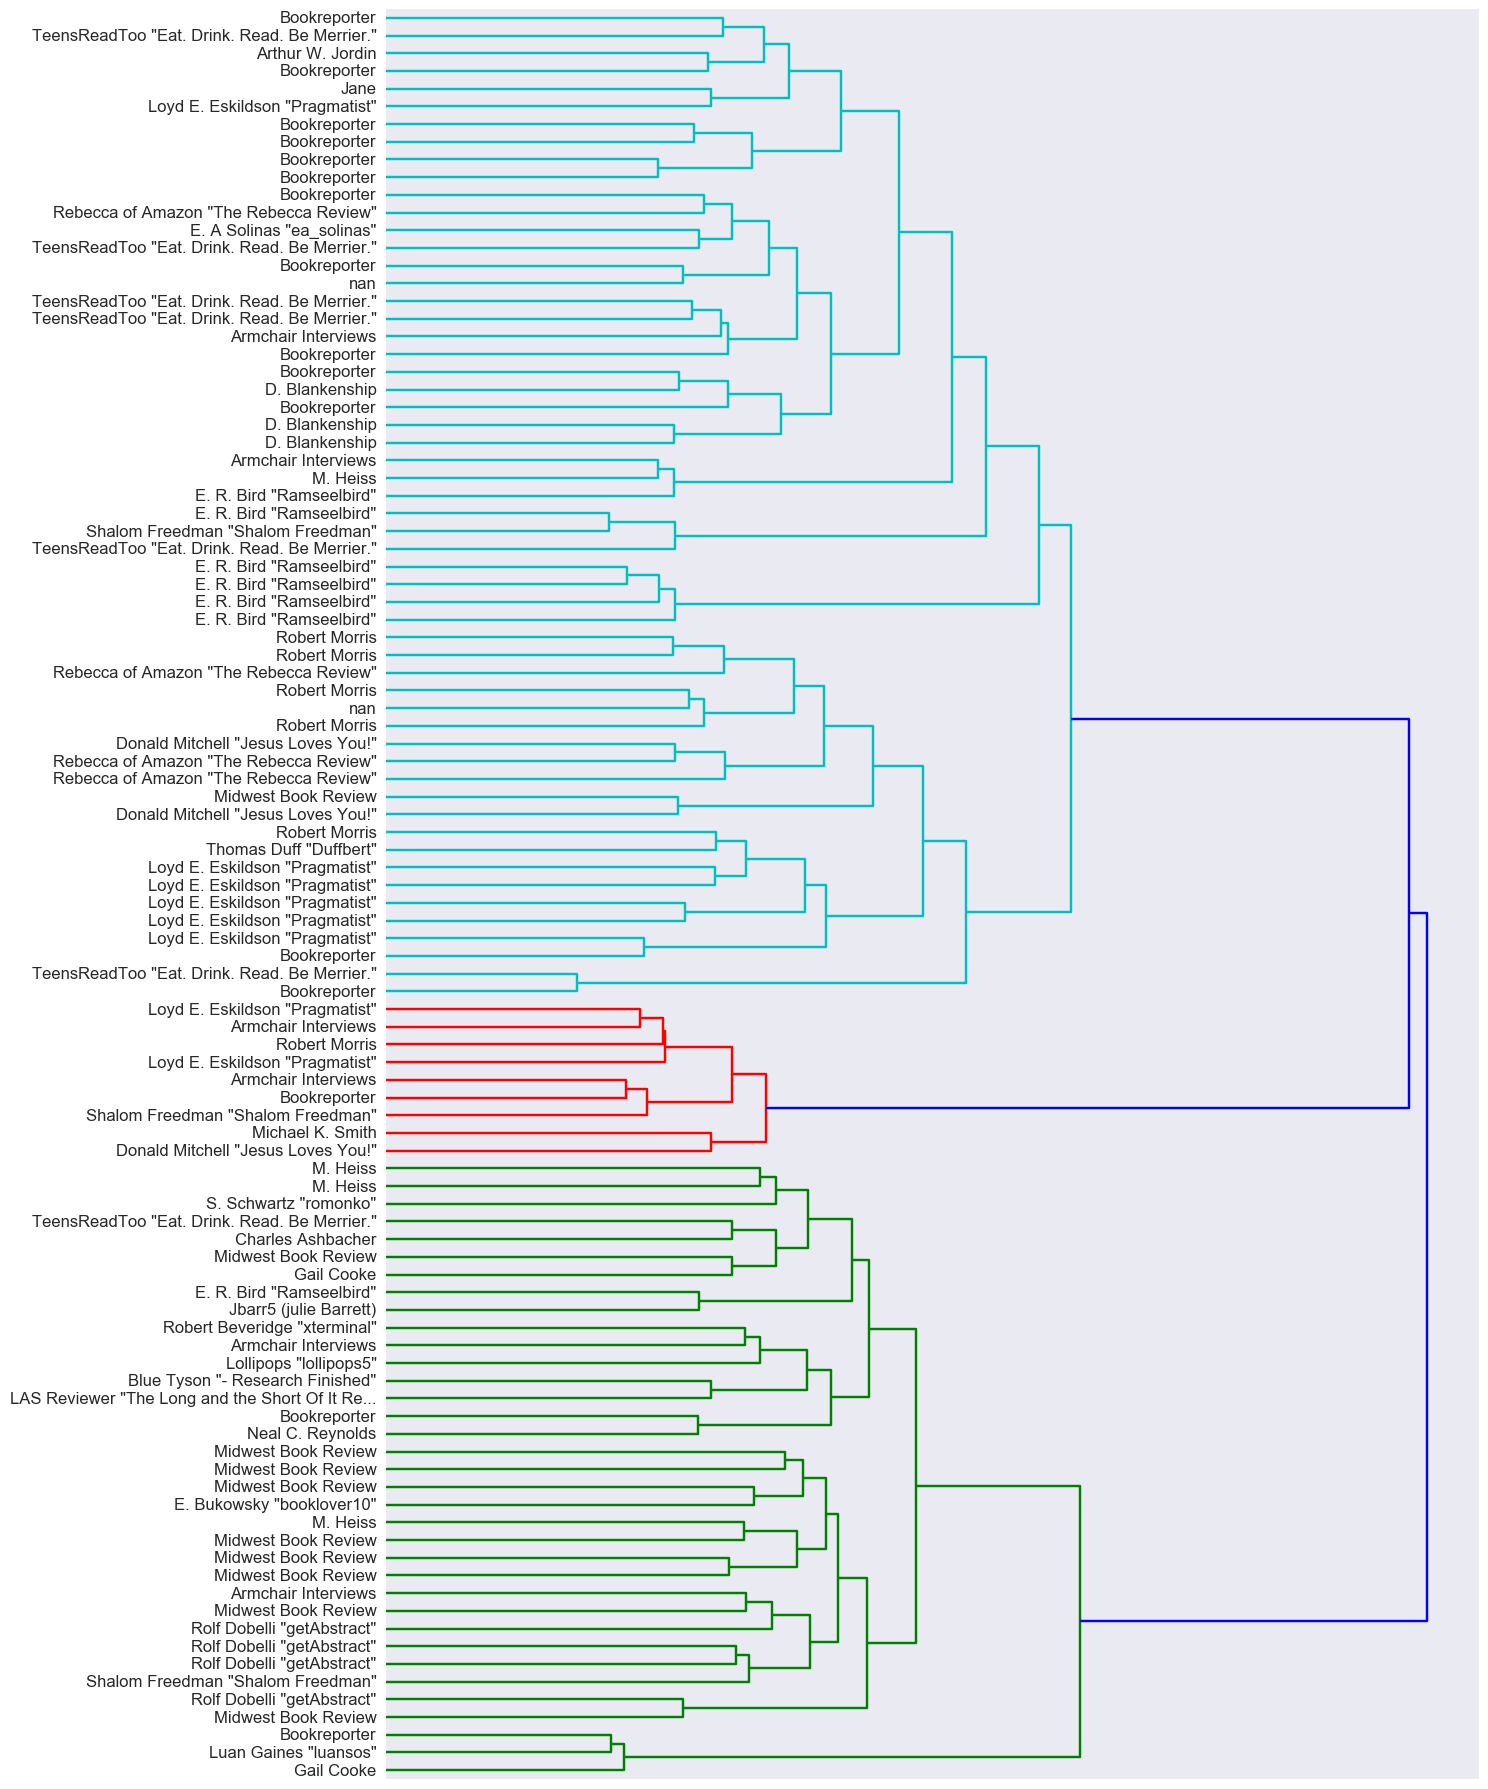

In [63]:
sns.set_style("dark")
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 18)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels = name);



plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.tight_layout() #show plot with tight layout
